In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import keras

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Model,Sequential
from keras.layers import Input, Dense, Dropout

from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt

In [2]:
# load data sets
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')

print(train_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [3]:
# data preprocessing
df = pd.DataFrame(train_data.data, columns=['text'])
df['target'] = pd.Series(train_data.target)

df_test = pd.DataFrame(test_data.data, columns=['text'])
df_test['target'] = pd.Series(test_data.target)

print(df.head(5))
print(df.info())

# check null
df.isnull().sum()

# check unique
df.nunique()

                                                text  target
0  From: lerxst@wam.umd.edu (where's my thing)\nS...       7
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...       4
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...       1
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB
None


text      11314
target       20
dtype: int64

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


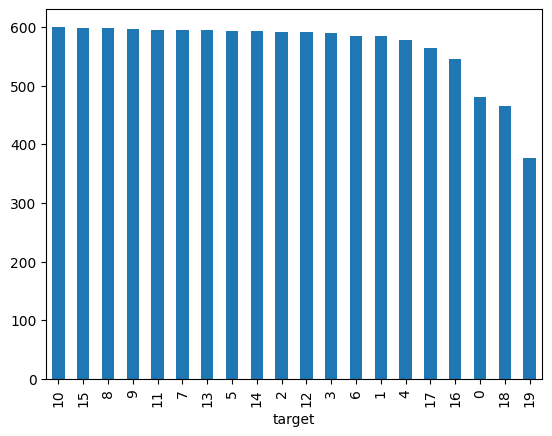

In [4]:
# check data distribution
df['target'].value_counts().plot(kind='bar')
print(df.groupby('target').size().reset_index(name='count'))

In [5]:
def tokenize(train_data, test_data, mode, num=10000):
    """
    tokenize data and return matrix
    
    if train and test data are tokenized separately,
    the number of words in train and test data will be different.

    """
    tokenizer = Tokenizer(num_words=num) # num_words: max number of words to keep based on frequency
    tokenizer.fit_on_texts(train_data) # map words to integers
    train_matrix = tokenizer.texts_to_matrix(train_data, mode=mode)
    test_matrix = tokenizer.texts_to_matrix(test_data, mode=mode)
    return train_matrix, test_matrix, tokenizer.index_word

In [6]:
X_train, X_test, index_word = tokenize(df['text'], df_test['text'], mode='binary')

y_train = to_categorical(df['target'])
y_test = to_categorical(df_test['target'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train[0])
print(index_word[1]) # most frequent word (0 is reserved for padding)

(11314, 10000) (11314, 20)
(7532, 10000) (7532, 20)
[0. 1. 1. ... 0. 0. 0.]
the


In [7]:
# modeling with multi-layer perceptron (MLP)
def model():
    model = Sequential()
    model.add(Dense(512, input_dim=X_train.shape[1], activation='relu')) # 10000 -> 512
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu')) # 512 -> 128
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1], activation='softmax')) # 128 -> 20
    model.summary()
    
    return model

def train(model, X_train, X_test, y_train, y_test):
    m = model()
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    m.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.1)
    score = m.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score

In [8]:
# main
modes = ['binary', 'count', 'tfidf', 'freq']
scores = []

for mode in modes:
    X_train, X_test, num_word = tokenize(df['text'], df_test['text'], mode=mode)
    
    y_train = to_categorical(df['target'])
    y_test = to_categorical(df_test['target'])
    
    score = train(model, X_train, X_test, y_train, y_test)
    scores.append([])
    scores[-1].append(score)
    print('mode: {}, accuracy: {}'.format(mode, score[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               5120512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 5188756 (19.79 MB)
Trainable params: 5188756 (19.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
80/80 

In [10]:
for mode, score in zip(modes, scores):
   print('mode: {}, accuracy: {}'.format(mode, score[0][1]))

mode: binary, accuracy: 0.8267392516136169
mode: count, accuracy: 0.8153212666511536
mode: tfidf, accuracy: 0.8243494629859924
mode: freq, accuracy: 0.7318109273910522
